In [1]:
from time import time
import pprint
import tqdm
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple,OrderedDict
from functools import partial

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier, DMatrix
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from unicodedata import category
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix


sns.set_style('darkgrid')
warnings.simplefilter('ignore')

In [2]:
path = "../input/english-premier-league-results/results.csv"
df = pd.read_csv(path, encoding='windows-1254')

def isolation_forest(data, iforest):
    # iforest in an instance of isolation_forest
    # Returns 1 of inliers, -1 for outliers
    pred = iforest.fit_predict(data)
    outlier_index = np.where(pred == -1)
    outlier_values = data.iloc[outlier_index]
    return outlier_index, outlier_values

iforest = IsolationForest(n_estimators=100, max_samples='auto',
                          contamination=0.1, max_features=1.0,
                          bootstrap=False, n_jobs=-1, random_state=1)

def preprocess(data):
    data.columns = [col.lower() for col in data.columns]
    data.datetime = pd.to_datetime(data.datetime).dt.date
    data.drop(data.loc[data['season'].str.contains(
        '1993|1994|1995|1996|1997|1998|1999', regex=True)].index, inplace=True)
    data.sort_values(['datetime', 'hometeam', 'awayteam',
                     'referee'], ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    points_h_map = {'H': 3, 'D': 1, 'A': 0}
    points_a_map = {'H': 0, 'D': 1, 'A': 3}
    data['hp'] = data['ftr'].map(points_h_map)
    data['ap'] = data['ftr'].map(points_a_map)
    data['hhp'] = data['htr'].map(points_h_map)
    data['hap'] = data['htr'].map(points_a_map)
#     index,values=isolation_forest(data.select_dtypes('number'),iforest)
#     data.drop(index[0],axis=0,inplace=True)
    return data


pack = {}
home = ['hometeam', 'fthg', 'hthg', 'hs',
        'hst', 'hc', 'hf', 'hy', 'hr', 'hp', 'hhp']
away = ['awayteam', 'ftag', 'htag', 'as',
        'ast', 'ac', 'af', 'ay', 'ar', 'ap', 'hap']
objects = ['season', 'datetime', 'ftr', 'htr', 'referee']
feature_names = ['ftg', 'htg', 's', 'st', 'c', 'f', 'y', 'r', 'p', 'hp']

data = preprocess(df)
data = data.reindex(columns=objects+home+away)

home_data = data[objects+home]
away_data = data[objects+away]

pack['data'] = data
pack['home_data'] = home_data
pack['away_data'] = away_data
pack['home'] = home
pack['away'] = away
pack['objects'] = objects
pack['feature_names'] = feature_names

In [3]:
class Features:
    def __init__(self, home, away, objects, feature_names, home_data, away_data, data):
        self.home = home
        self.away = away
        self.objects = objects
        self.feature_names = feature_names
        self.home_data1 = home_data.copy()
        self.away_data1 = away_data.copy()
        self.home_data = home_data.copy()
        self.away_data = away_data.copy()
        self.data = data

    def rol_hac(self):
        # rolling home and away combined
        """making a rolling of all attributes representing a team offense"""

        self.away_data1.columns = self.objects + self.home  # changed away to look like home
        combined_data = pd.concat([self.home_data1, self.away_data1],
                                  ignore_index=True)  # cancatted it
        combined_data['identification'] = np.array([np.ones(self.home_data1.shape[0]), np.zeros(
            self.home_data1.shape[0])], dtype=np.int64).reshape(-1, 1)  # making an identifier to split later
        # combined data-very important its data raveled vertically

        rol_hac = pd.DataFrame(index=combined_data.index)
        features_to_rol = self.home[1:]
        for col in features_to_rol:
            feature = combined_data.groupby('hometeam', as_index=False)[col].rolling(
                window=10, center=True, min_periods=5).mean().shift(1).fillna(method='bfill')[col]
            rol_hac[col] = feature
        home_df = rol_hac[combined_data.identification == 1]
        away_df = rol_hac[combined_data.identification ==
                          0].reset_index(drop=True)
        # hr-home rolling but its offensive
        home_df.columns = [i+'_hr'for i in self.feature_names]
        # away rolling but offensive
        away_df.columns = [i+'_ar'for i in self.feature_names]
        # suffixes are for overlapping columns
        rol_features = home_df.join(away_df)
        return rol_features

    def rol_hac_d(self):
        """this features are rolling home and away combined attributes(attributes like home shots,home fouls away yellow acrds etc )
        conceded by home and away teams until the previous match
        hs_c=shots conceded by the  home team until the previous match
        ha_c=shots conceded by the away team until the previous match ,i think you get the idea
        """

        self.home_data.columns = self.objects+self.away  # changed away to look like home
        combined_data = pd.concat([self.away_data, self.home_data],
                                  ignore_index=True)  # cancatted it
        combined_data['identification'] = np.array([np.ones(self.home_data.shape[0]), np.zeros(
            self.home_data.shape[0])], dtype=np.int64).reshape(-1, 1)  # making an identifier to split later
        # ones represent what is home teams defence and zeros represent away teams defence

        rol_hac = pd.DataFrame(index=combined_data.index)
        features_to_rol = self.away[1:]
        for col in features_to_rol:
            feature = combined_data.groupby('awayteam', as_index=False)[col].rolling(
                window=10, center=True, min_periods=5).mean().shift(1).fillna(method='bfill')[col]
            rol_hac[col] = feature  # c indicates conceded
        home_df = rol_hac[combined_data.identification == 1]
        # -chr-conceded home rolling
        home_df.columns = [i+'_chr'for i in self.feature_names]
        away_df = rol_hac[combined_data.identification ==
                          0].reset_index(drop=True)
        # -car-conceded away rolling
        away_df.columns = [i+'_car'for i in self.feature_names]
        rol_features = home_df.join(away_df)
        return rol_features

    def other_features(self, data):
        data['day'] = data['datetime'].apply(lambda x: x.isoweekday())
        data.ftr = data.ftr.map({'H': 2, 'A': 1, 'D': 0})
        data.htr = data.htr.map({'H': 2, 'A': 1, 'D': 0})
        return data

    def execute(self):
        rollin_features_a = self.rol_hac()
        rollin_features_d = self.rol_hac_d()
        object_data = self.data[self.objects+['hometeam', 'awayteam']]
        data = object_data.join([rollin_features_a, rollin_features_d])
        data_all_features = self.other_features(data)
        return data_all_features


def encoder(data, features):
    from sklearn.preprocessing import OrdinalEncoder
    oe = OrdinalEncoder()
    data[features] = oe.fit_transform(data[features])
    return data


def features_targets(data, selected_features=None):
    # data = data.select_dtypes('number')  #selecting only numerical features for starters
    container = namedtuple('container', ['trainx', 'trainy'])
    if selected_features is not None:
        features = data[selected_features]
    else:
        features=data
    # these not rolling original results for reference dont need anymore!
    ind_feats = features.drop(['ftr', 'htr','datetime','referee'], axis=1)
    ind_feats = encoder(ind_feats, ['hometeam', 'awayteam', 'season'])
    datas = container(ind_feats, features['ftr'])
    return datas


def mutual_information(x, y, mask=None):
    """function calculates the mi score in descendinhg trend given x and y"""
    if mask is not None:
        mi = mutual_info_classif(x.iloc[:, :mask], y)
        mi = pd.DataFrame(mi, columns=['mi_score'], index=x.columns[:mask])
    elif mask is None:
        mi = mutual_info_classif(x, y)
        mi = pd.DataFrame(mi, columns=['mi_score'], index=x.columns)

    mi = mi.sort_values("mi_score", ascending=False)
    return mi


def pca_ing(x, standardize=True):
    """function standardizes the data is not standardized and performs pca and outputs its componets in a df also loadings"""
    if standardize:
        sc = StandardScaler()
        x_scaled = sc.fit_transform(x)
        x = pd.DataFrame(x_scaled, columns=x.columns)
    pca = PCA()
    x_pca = pca.fit_transform(x)
    components = [f'pca_{i}' for i in x.columns.values]
    x_pca = pd.DataFrame(x_pca, columns=components)
    loadings = pd.DataFrame(
        pca.components_.T, columns=components, index=x.columns)
    return x_pca, loadings


def auto_best_features(x, y,  n_features, standardize_on_pca=True):
    """best n_features(having most mi scores) among x and its pca version n_features=-1 for all features """
    x_pca, _ = pca_ing(x, standardize=standardize_on_pca)
    x.reset_index(drop=True, inplace=True)
    all_features = x.join(x_pca)
    mutual_info = mutual_information(all_features, y)
    selected_cols = mutual_info.index.values[:n_features]
    return all_features[selected_cols]


def plotmi(mi):
    sns.set_style('darkgrid')
    plt.figure(figsize=(5, 20), dpi=100)
    sns.barplot(mi['mi_score'], mi.index)


In [4]:
model = XGBClassifier(random_state=0, 
                      objective='multi:softprob',
                      tree_method='gpu_hist',
                      verbosity=1,
                      num_class=3
                     )

# scoring = make_scorer(partial(accuracy_score), greater_is_better=True)
overdone_control = DeltaYStopper(delta=0.0001)
time_limit_control = DeadlineStopper(total_time=60*60*1)

search_spaces = {              
            
                'n_estimators': Integer(1, 500), #nmber of boosting steps
                'max_depth': Integer(1, 100),  #max depth of base estimator
                'learning_rate': Real(0.001, 1.0, 'uniform'), #weight in combining each steap of the boost must be small if n_estimators are very large
                'reg_lambda': Real(1e-9, 5., 'uniform'), #l2 ref param
                'max_leaves' : Integer(1,100), 
                'booster' : Categorical(['gbtree','gblinear','dart']),
                'subsample': Real(0.1, 1.0, 'uniform'), #regularization by only using a randaom set given fraction of rows for traning each boost step
                'sampling_method':Categorical(['uniform','gradient_based']),
                'colsample_bytree': Real(0.1, 1.0, 'uniform'), #regularization by only using a random set of given fraction of column in each boost step 
                'predictor': Categorical(['gpu_predictor']),
                'grow_policy': Categorical(['depthwise','lossguide'])
    
#                 'max_bin':
#                 'gamma':
#                 'gpu_id':
#                 'monotone_constraints':
#                 'interaction_constraints':
#                 'single_precision_histogram':
                
                 }

# num_iterations=1000,
# feature_fraction=0.7,
# scale_pos_weight=1.5,


def optimizer(trainx, trainy, title, callbacks=None):

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0) #controllable split size-take care
    cv_strategy = skf.split(trainx, trainy)
    optimizer_fn = BayesSearchCV(estimator=model,
                              search_spaces=search_spaces,
                              scoring='f1_weighted',
                              cv=cv_strategy,
                              n_iter=120,
                              n_points=1,
                              n_jobs=1,
                              iid=False,
                              return_train_score=False,
                              refit=False,
                              optimizer_kwargs={'base_estimator': 'GP'},
                              random_state=0)

    
    start = time()
    if callbacks is not None:
        tqdm(optimizer_fn.fit(trainx, trainy, callback=[overdone_control, time_limit_control]))
    else:
        optimizer_fn.fit(trainx, trainy)

    d = pd.DataFrame(optimizer_fn.cv_results_)
    best_score = optimizer_fn.best_score_
    best_score_std = d.iloc[optimizer_fn.best_index_].std_test_score
    best_params = optimizer_fn.best_params_

    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f " + u"\u00B1" +
          " %.3f") % (time() - start, len(optimizer_fn.cv_results_['params']), best_score, best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    return best_params

In [5]:
feat = Features(**pack)
data = feat.execute()
container = features_targets(data)
trainx = container.trainx
trainy = container.trainy

trainx,valx,trainy,valy=train_test_split(trainx,trainy,test_size=0.2,stratify=trainy)
trainx.reset_index(inplace=True,drop=True)
valx.reset_index(inplace=True,drop=True)
trainy.reset_index(inplace=True,drop=True)
valy.reset_index(inplace=True,drop=True)

In [6]:
best_params = optimizer(trainx,trainy, 'XGBoost_classif')
model.set_params(**best_params)
model.fit(trainx,trainy)
t_preds=model.predict(trainx)
v_preds=model.predict(valx)

[12:52:39] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "grow_policy", "max_depth", "max_leaves", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:52:40] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "grow_policy", "max_depth", "max_leaves", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:52:40] WARNING: ../src/learner.cc:627: 
Parameters: { "col

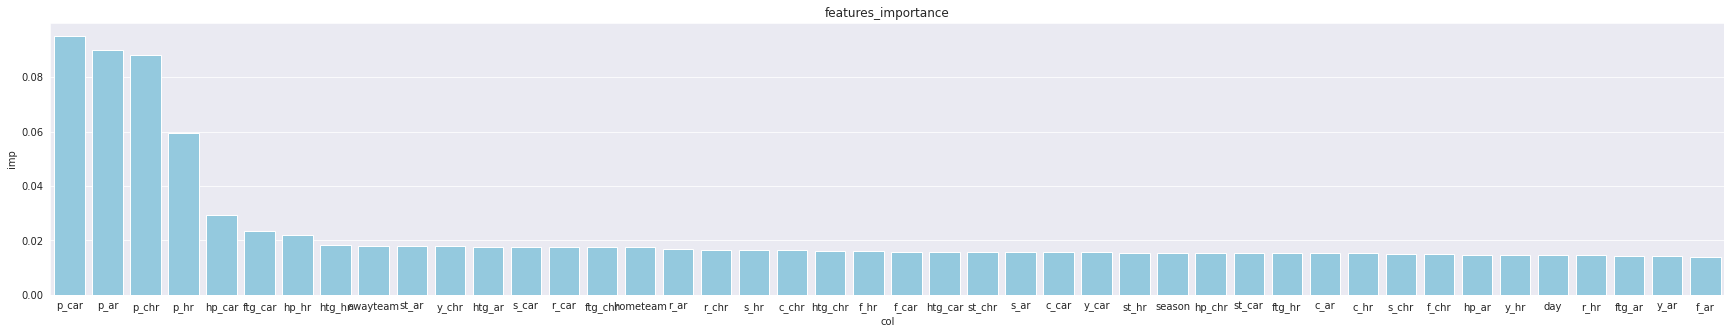

In [7]:
plt.figure(figsize=(30,5))
imp=pd.DataFrame({'col':trainx.columns,'imp':model.feature_importances_})
imp.sort_values('imp',ascending=False,inplace=True)
imp.reset_index(drop=True,inplace=True)
plt.title('features_importance')
sns.barplot(imp['col'],imp['imp'],color='skyblue');


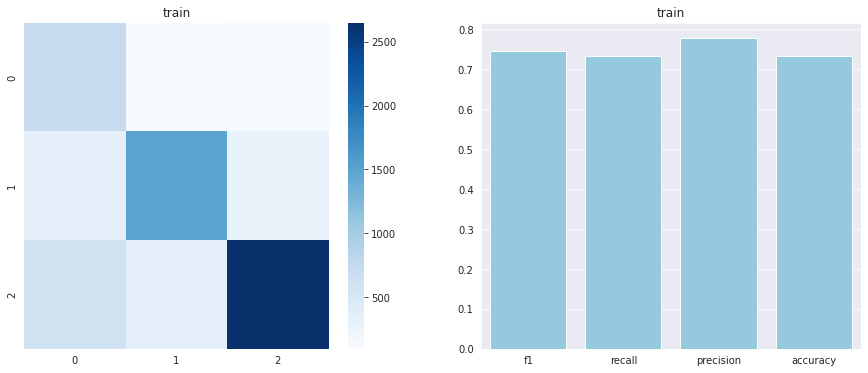

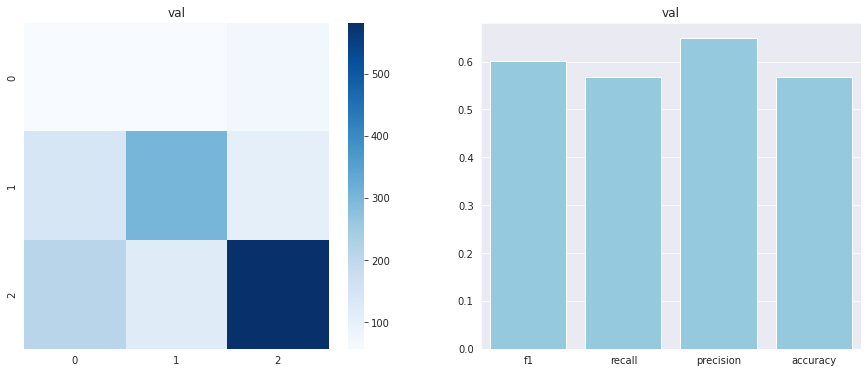

In [8]:
def return_matrics(preds,targets,title):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.title(title)
    sns.heatmap(confusion_matrix(preds,targets),cmap='Blues');
    scores=[f1_score(preds,targets,average='weighted'),recall_score(preds,targets,average='weighted'),precision_score(preds,targets,average='weighted'),accuracy_score(preds,targets)]
    score_names=['f1','recall','precision','accuracy']
    plt.subplot(1, 2, 2)
    plt.title(title)
    sns.barplot(score_names,scores,color='skyblue');
    
return_matrics(t_preds,trainy,'train')
return_matrics(v_preds,valy,'val')